# Training a Text Classifier

In this notebook we will create a news classifier using the Eduge dataset.

## Library Installs and Imports

We will need several libraries to get started. Each should be installed and upgraded to ensure it works. This notebook was created in February 2020 and should work with the following major verisons:

- Fast.ai version 2.x
- Fastcore version: 1.x
- Pandas version: 1.x
- Numpy version: 1.x

In [1]:
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade
!pip install -Uqq pandas==1.1.0

In [2]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.2.7
Fastcore version: 1.3.19


In [3]:
from fastai.text.all import *
from fastai.callback.progress import CSVLogger
import pandas as pd
import numpy as np
print('Pandas version:', pd.__version__)
print('numpy version:', np.__version__)

Pandas version: 1.1.0
numpy version: 1.19.5


We will be using Google Drive to store our files. Please change the directory for the `cd` command to wherever your notebook is located. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd '/content/drive/MyDrive/DataScience/NLP/01_eduge_classification'

/content/drive/MyDrive/DataScience/NLP/01_eduge_classification


## Load Dataset

In [8]:
df = pd.read_csv('data/news.csv')

In [9]:
df = df.rename(columns={'news':'text'})

In [10]:
np.random.seed(42)

In [11]:
df['is_valid'] = np.random.choice([0,1], size=len(df), p=[0.9, 0.1])

In [12]:
df.head(2)

,text,label,is_valid
0,"Киноны кадраас «Юрийн галавын үе» кино прокатад тавигдсныхаа дараах эхний амралтын өдрөөр хамгийн их орлого оллоо гэж Business Insider хэвлэл мэдээлэв. Хойд Америкт л гэхэд эхний амралтын өдрүүдэд 204,6 сая доллар цуглуулж чадлаа. Гадаад орнуудын үзүүлэлт нь 307,2 сая ам.доллар байв. Нийт кассын орлого 511,8 сая ам.доллар болжээ. Энэхүү үзүүлэлт нь Universal кино компанийн дээд амжилт төдийгүй дэлхийн кино аж үйлдвэрийн томоохон үсрэлт боллоо. Үүнээс өмнө амралтын эхний өдрүүдэд 500 сая долларын босго давсан их мөнгө цуглуулж байсан түүх байхгүй. «Гарри Поттер ба үхлийн тахил: II хэсэг» 48...",урлаг соёл,0
1,"“Universal” кино компани Жадд Апатоугийн найруулж, “Lonely Island” гэдэг хошин шогийн хамтлагийнхны гол дүрүүдэд нь тоглож байгаа киног 2016 оны зургадугаар сарын 3-нд дэлгэцнээ гаргахаар төлөвлөсөн тухай The Hollywood Reporter мэдээлж байна. Шинэ киноны нэрийг одоохондоо өгөөгүй гэнэ. Кинонд инээдмийн жүжигчид Энди Сэмберг, Йорма Таккоме, Акива Шаффер нар тогложээ. Сүүлийн жилүүдэд гарч ирсэн баримтат киноны элэглэл нь шинэ кино болох ёстой. Энд Жастин Бибер, Кэти Перри нарын элэглэл хамгийн түрүүнд дүрслэгдэх аж. “Lonely Island” хошин шогийн хамтлагийнхан “Saturday Night Live” гэдэгт нэв...",урлаг соёл,1


In [13]:
with open('models/mn_eduge_vocab.pkl', 'rb') as f:
      vocab = pickle.load(f)

For some reason passing `label` to the `ColReader` for `get_y` threw an error. So I'm using the index of the column to reference the label.

In [14]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', vocab=vocab), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader(1), 
                    splitter=ColSplitter())

In [15]:
dls = dblocks.dataloaders(df)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [16]:
dls.show_batch()

,text,category
0,"xxbos монгол улсын ерөнхийлөгч цахиагийн элбэгдорж “ news ” агентлагийн урилгыг хүлээн авч , уншигчдын асуултад хариуллаа . морин жилд арван жилийнхээ ойг тэмдэглэсэн мэдээллийн “ news ” агентлаг 2004 - 2014 онд шалгарсан “ оны xxunk цуврал ярилцлага хийж байгаагийн анхны зочин монгол улсын ерөнхийлөгч цахиагийн элбэгдорж боллоо . өмнө нь “ ньюс xxunk монгол улсын ерөнхийлөгчтэй “ xxunk ” гэсэн сонирхолтой ярилцлагыг өрнүүлж , олон түмэндээ хүргэж байсан . энэ удаа бид хоёр өдрийн турш xxunk асуулт авсан бөгөөд уншигчдаас нийт 461 асуулт ирснээс 40 орчмыг багцлан , ерөнхийлөгчид тавьсан юм . ярилцлагыг “ ньюс xxunk ерөнхий редактор xxunk тэмүүлэн хөтлөв . xxunk байгаа морин жил монголчуудад маань хэр ээлтэй байв , таны бодлоор . бидний олсон ололт , алдаа юу байв ? -морин жилүүд монголчуудад ээлтэй байсан . улирч байгаа морин жил маань монгол түмэнд ээлээ өглөө . морин жилдээ монголчууд 3 саяулаа боллоо . амны",улс төр
1,"xxbos уих - ын гишүүн л.эрдэнэчимэг , "" өглөөний хүн "" ярилцлагын булан , 2014 монголчууд бид архины хор уршгийг хангалттай л ярьсан . харин энэ хорт зуршлыг бууруулах зорилготой хууль энэ хаврын чуулганаар хэлэлцэгдэнэ . ▁ энэхүү хууль хэлэлцэгдэх гэж байгаатай холбоотойгоор эсрэг байр суурьтай байгаа лобби бүлгүүд хэвлэлээр , олон нийтийн сүлжээгээр улам бүр идэвхжиж байгаа нь xxunk байна . ▁ тэд хуулийн ямар учир xxunk сайн мэдэхгүйдээ ингэж байна уу эсвэл мэдсээр байж архины хяналтын тухай хуулийг санаатай xxunk шаргуу бичиж байна уу гэдэг сонирхолтой . ▁ яах аргагүй цаг үеийн халуун сэдэв болоод байгаа энэхүү хуулийн гол санаачлагчдын нэг уих - ын гишүүн xxunk бид "" өглөөний хүн "" ярилцлагын буландаа урьсан юм . бидний ярианы дийлэнх хэсэг архи , тамхитай холбоотой . ▁ ярих л ёстой асуудал . нэг талдаа гарах учиртай . ▁ ингээд ▁ ikon.mn сайтын шинийг санаачлагч , хөдөлмөрч , манлайлагчдын цуврал",улс төр
2,"xxbos тун удахгүй уих - аар “ шинэ тө­мөр зам”-ын царигийн асууд­лыг xxunk н xxunk нэ . өргөн , нарийн гэсэн хоёр царигийн аль нь монгол улсад ашиг тусаа өгөх талаар улс төрчид болон бизнесийнхэн маргалдан , ширүүхэн үзэлцэж эхэллээ . энэ асуултын хариултыг бид төмөр замд 40 шахам жил төмөр замыг арчлах , шинээр барих , их засвар хийж засч шинэчлэх , замын зураг төсөл , тооцоо судалгааг хийж ирсэн ахмад төмөр замчин , инженер xxunk ярилцлаа . -төмөр зам барих асуудал өмнө нь ингэж дуулиан шуугиан болж байсангүй . нарийн цариг хэрэгтэй юу ? эсвэл өргөн цариг нь ашигтай юу ? ▁ гэсэн асуултын хариуг хүмүүс яг энэ цаг мөчид ч хайсаар л байна ? - би өмнө ч бас ярьж л байсан даа . далайд гарцгүй , дэлхийн хоёр их геополитикийн дунд оршдог манай улсын хувьд гадагш баялгаа зарж борлуулан хөгжлийн түлхүүр болгоход дэд бүтцийн хамгийн чухал",эдийн засаг
3,"xxbos "" өдрийн xxunk xxunk дугаарт нийтлэгдсэн уих - ын гишүүн х.баттулгын ярилцлагыг зохиогчийн зөвшөөрөлтэйгөөр нийтэлж байна . ▁ -хөгжлийн бодлогоо гаргаад гадны хөрөнгө оруулагчдад мессэж болгон өгөх xxunk уих - ын гишүүн xxunk ярилцлаа . xxunk тивийн орнууд бүхэлдээ азийн олимпдоо анхаарал хандуулж бай­на . азийн наадмын салхийг xxunk маш амжилттай хагалж гурван алт , гурван мөнгө , дөр­вөн хүрэл медальтай xxunk . жүдо бөх 2008 оны олимпоос хойш илт сэргэсэн нь таныг холбооны тэргүүнээр xxunk салшгүй холбоотой гэдэг . та холбоогоо ямар чиглэлд удирддаг вэ ? -дэлхийн долоон тэрбум хүний дөрвөн тэрбум нь ази тивд амьдардаг . тиймээс ээлжит xxunk зохион бай­гуулж байгаа нь ази тивийн том амбиц юм уу даа . дөрвөн тэрбум хүнээс xxunk тэмцээн гэхээр яах аргагүй том байж таарна . манайхан бөх , боксын төрөлд л амжилт гаргадаг байсан . тэгвэл энэ азийн наадамд нэг шинэлэг зүйл нь манай сагсан xxunk тамирчид байлаа .",улс төр
4,"xxbos муугз д.цэцэрлэг энэ удаагийн “ чухал хүн ” буландаа хэдхэн хоногийн өмнө муугз хэмээх эрхэм хүндтэй цол , тэмдгээр энгэрээ мялаасан xxunk цэцэрлэгийг урьж , ярилцлаа . ▁ -юуны өмнө танд уншигчдынхаа өмнөөс муугз хэмээх эрхэм хүндтэй цол , xxunk энгэрээ xxunk баяр хүргэе . сэтгэгдлээсээ манай уншигчидтай хуваа

We can see the categories by looking into the `dls.vocab` object. The first element of `dls.vocab` is the vocabulary for the entire corpus. The second element is the categories.

In [17]:
dls.vocab[1]

['байгал орчин', 'боловсрол', 'спорт', 'технологи', 'улс төр', 'урлаг соёл', 'хууль', 'эдийн засаг', 'эрүүл мэнд']

## Build Classifier

In [18]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[accuracy]).to_fp16()

In [19]:
notebook_path = Path('').absolute()

In [20]:
notebook_path

Path('/content/drive/My Drive/DataScience/NLP/01_eduge_classification')

In [21]:
learn.path = notebook_path

In [22]:
learn.load_encoder(notebook_path/'models/mn_eduge_lm_encoder')

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.004365158267319202)

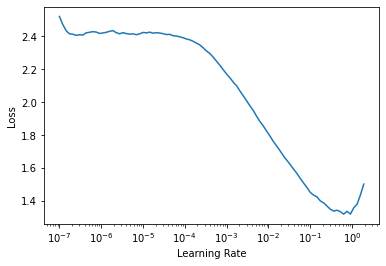

In [23]:
learn.lr_find()

In [24]:
lr = 0.06

In [25]:
cbs=[CSVLogger(fname='history_eduge_classification.csv')]

In [26]:
learn.fine_tune(10, lr, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.444879,0.341088,0.894193,04:48


epoch,train_loss,valid_loss,accuracy,time
0,0.272099,0.227450,0.922489,10:46
1,0.283359,0.256825,0.921953,10:48
2,0.290664,0.241243,0.925037,10:49
3,0.254660,0.246554,0.923696,10:48
4,0.236787,0.296020,0.921818,10:48
5,0.206620,0.253772,0.928255,10:50
6,0.187037,0.222824,0.929462,10:50
7,0.133402,0.220681,0.932144,10:48
8,0.129653,0.223627,0.933351,10:49
9,0.106175,0.230003,0.935095,10:48


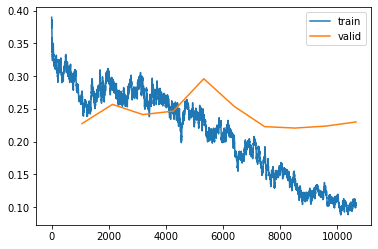

In [27]:
learn.recorder.plot_loss()